<a href="https://colab.research.google.com/github/human-centered-ai-lab/app-covid-19-playground/blob/master/covid_19_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Read the data values

In [1]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from scipy import signal
import psycopg2 as ps
import seaborn as sns
import pandas as pd
import numpy  as np
import requests
import math
import json

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

r = requests.get(url = "https://pomber.github.io/covid19/timeseries.json") 
data = r.json() 

countries = sorted(data.keys())
#print ("ALL COUNTRIES WITH DATA AVAILABLE at pomber.github.io")
#print (countries)

countriesOfInterest = ['Austria', 'Belgium','Czechia', 'Denmark', 'Finland', 'France', 'Germany', 'Hungary',  'Italy', 'Malta','Netherlands',  'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'US', 'United Kingdom']
population = {}
for c in countriesOfInterest:
  r = requests.get(url = "https://restcountries.eu/rest/v2/name/" + c) 
  cinforeq = r.json() 
  if ( r.status_code == 200):
      population[c] = cinforeq[0]['population']
  else:
      population[c] = 999999999999999999999999
population.update ({'Czechia' : 10703551})
population.update ({'US' : 330467650})

#print ("COUNTRIES OF INTEREST WITH POPULATION")
#print (population)

start_date = date(2020, 3, 8)
end_date   = date(2020, 3, 30)


endDateForDiagram  = ( datetime.now()+timedelta(days=1)).date()
endDateForDiagram  =  datetime.now().date()

#endDateForDiagram  =  date(2020, 3, 30)

print (endDateForDiagram)

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2020-04-06



# Number of Cases (logarthmic scale) per 1.000.000 inhabitants



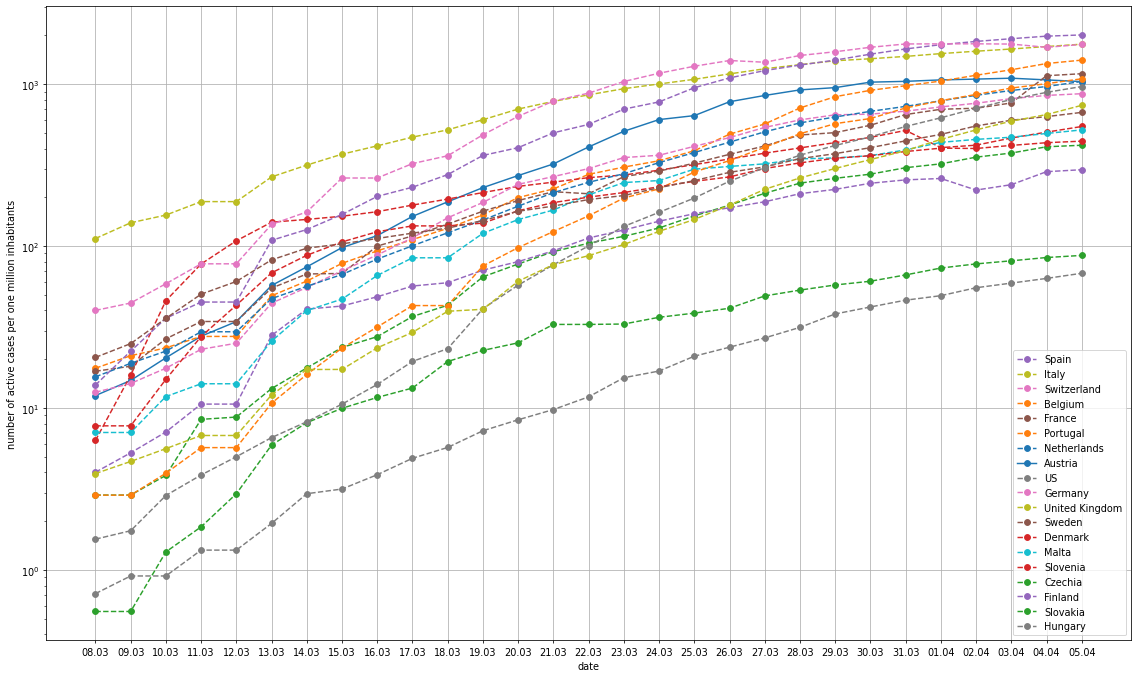

In [3]:
width_in_inches = 20
height_in_inches = 12
dots_per_inch = 70

plt.figure( figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

#countriesOfInterest = ['Austria', 'Czechia', 'Germany', 'Italy', 'US', 'United Kingdom', 'Slovenia', 'Denmark' ]

datesToInspect = []
x_axis_data = [];
for single_date in daterange(start_date, endDateForDiagram):
    x_axis_data.append(single_date.strftime("%d.%m"))
    datesToInspect.append(single_date.strftime("%Y-%-m-%-d"))

lines = []
labels = []
numberToOrder = {}
i = 0
for c in countriesOfInterest:
        y_axis_data = []
        for dataindex in datesToInspect:
            datafromonecontry = data[c]
            for daydata in datafromonecontry:
                #print (daydata['date'], dataindex)
                if daydata['date'] == dataindex:
                    cc = daydata['confirmed'] - daydata['recovered'] 
                    normalizedcc = cc * 1000000 / population[c]
                    v = normalizedcc
                    numberToOrder[i] = v
                    y_axis_data.append(v)
        ls = 'solid' if c == 'Austria' else '--'    
        lines, = plt.plot(x_axis_data,  y_axis_data, label=c, linestyle=ls, marker='o')
        labels.append (c)
        i = i + 1

LabelOrdering = []
for e in sorted(numberToOrder.items(), key=lambda x: x[1], reverse=True):
  LabelOrdering.append (e[0])

plt.yscale('log')
plt.xlabel("date")
plt.ylabel("number of active cases per one million inhabitants")
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in LabelOrdering],[labels[idx] for idx in LabelOrdering], loc='lower right')
plt.show()



# **Growth rate**

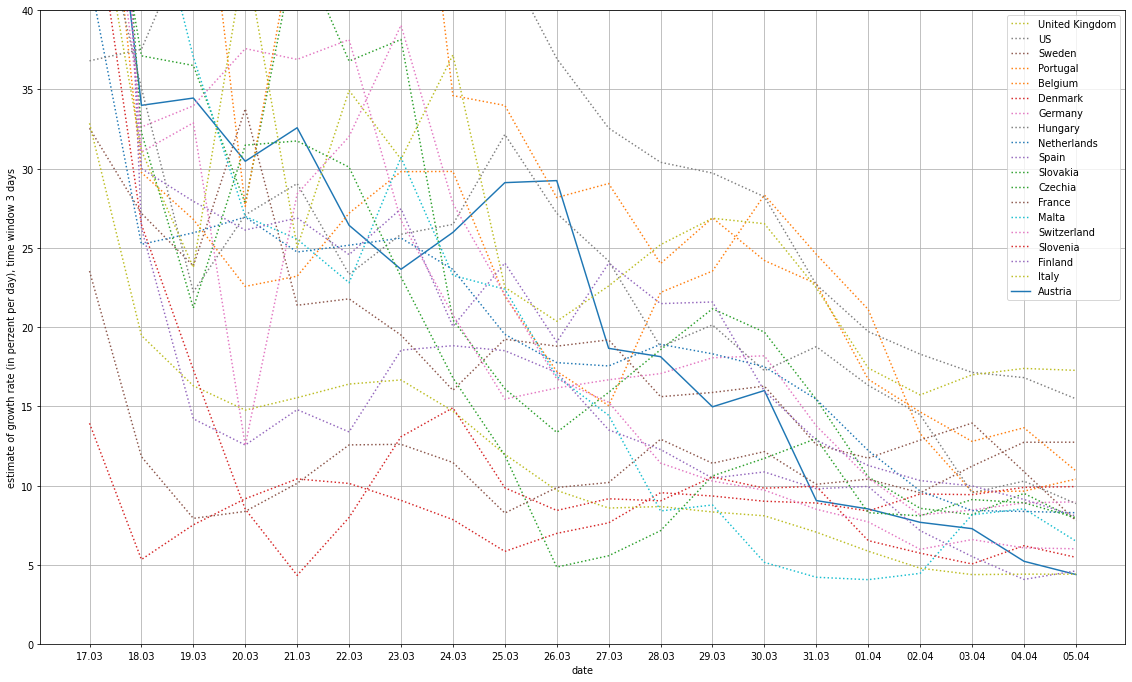

In [12]:
# delta growth rate computing
deltaInDays = 3

startDate = date(2020, 3, 17)

dateIndexMapper = []
datesToConsider = []

for sd in daterange(date(2020, 3, 5), endDateForDiagram):
    datesToConsider.append (sd)

for sd in reversed (datesToConsider ):
    dateIndexMapper.append (sd.strftime("%Y-%-m-%-d"))

plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

datesToInspect = []
x_axis_data = [];

for single_date in daterange(startDate, endDateForDiagram ):
        x_axis_data.append(single_date.strftime("%d.%m"))
        datesToInspect.append(single_date)

lines = []
labels = []
numberOfDays = len(datesToInspect)
numberToOrder = {}

i = 0
plt.ylim(0, 40)

for c in countriesOfInterest:
        y_axis_data = []
        for dataindex, datestringend in enumerate(datesToInspect):
            dateIndexReverse = 1 + len(datesToInspect) - dataindex
            datafromonecontry = data[c]
            fromcc = 0
            tocc  = 0
            
            for daydata in datafromonecontry:
                if daydata['date'] == dateIndexMapper [dateIndexReverse+deltaInDays]:
                    fromcc = daydata['confirmed']
            for daydata in datafromonecontry:
                if daydata['date'] == dateIndexMapper [dateIndexReverse]:
                    tocc  = daydata['confirmed']

            if fromcc  == 0:
                v = 0
            else:       
                v = 100 * (tocc-fromcc) / fromcc  / deltaInDays
                    
            numberToOrder[i] = v
            y_axis_data.append(v)

        ls = 'solid' if c == 'Austria' else 'dotted'
        lines, = plt.plot(x_axis_data,  y_axis_data, label=c, linestyle=ls)
        labels.append (c)
        i = i + 1 

LabelOrdering = []
for e in sorted(numberToOrder.items(), key=lambda x: x[1], reverse=True):
        LabelOrdering.append (e[0])

plt.xlabel("date")
plt.ylabel("estimate of growth rate (in perzent per day), time window 3 days")
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend([handles[idx] for idx in LabelOrdering],[labels[idx] for idx in LabelOrdering], loc='upper right')

